In this assignment, the support vector machine (SVM) and the Min-Max-Module
strategy will be used to deal with multi-class classification problems. SVMs usually
handle binary classification tasks. If there are several classes to recognize, some
strategies are needed. The most common methods are one-vs-one strategy, one-vs-rest
strategy, and part-vs-part strategy.

In [16]:
# coding: utf-8
# multi-class SVM using one versus rest policy
# multi-class SVM using Min-Max framework

import time
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.metrics import accuracy_score

hidden_size=100
output_size=3
batch_size=50
beta = 0.1 # regularization


In [17]:
def load_data():
    data_dir = "train_test"
    X_train = np.load(data_dir + "/" + "train_data.npy")
    X_test = np.load(data_dir + "/" + "test_data.npy")
    y_train = np.load(data_dir + "/" + "train_label.npy").astype(int)
    y_test = np.load(data_dir + "/" + "test_label.npy").astype(int)
    return X_train, X_test, y_train, y_test

In [18]:
def normalize(X):
    # make data balanced in every axis
    mean = X.mean(axis=0)
    var = X.std(axis=0)
    return (X - mean) / var, mean, var

In [19]:
def shift(y_in):
    # make labels start from 0
    y = y_in.ravel()
    return y_in - y.min()

In [20]:
def visual_2D(X, y, vtype="PCA"):
    
    if vtype == "PCA":
        pca = PCA(n_components=2)
        X_r = pca.fit(X).transform(X)
    elif vtype == "TSNE":
        pca = PCA(n_components=5)
        X_r = pca.fit(X).transform(X)
        print X_r.shape
        X_r = TSNE(n_components=2).fit_transform(X_r)
    else:
        return -1
    # plot 
    plt.figure()
    colors = ['navy', 'turquoise', 'darkorange']
    lw = 2
    target_names = ["-1", "0", "1"]
    for color, i, target_name in zip(colors, [-1, 0, 1], target_names):
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of Input dataset')
    plt.show()

In [21]:
def lb2vec(y_in):
    y = y_in.ravel()
    a = y - y.min()
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size),a] = 1
    return b

In [22]:
def accuracy(y, label):
    return (y==label) / y.size

In [23]:
X_train, X_test, y_train, y_test = load_data()

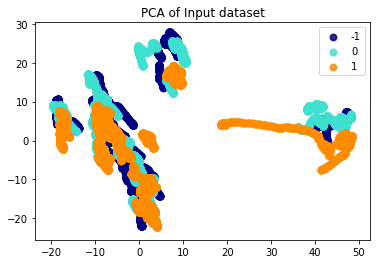

In [26]:
# visualize original data in 2D
# visual_2D(X_train, y_train, vtype="TSNE")
visual_2D(X_train, y_train)


In [10]:
X_train, X_train_mean, X_train_var = normalize(X_train)
# X_test = normalize(X_test)
X_test = (X_test - X_train_mean) / X_train_var
# ravel: extend y to a list. match sklearn version
y_train = shift(y_train)
y_test = shift(y_test)
X_train_sm = X_train[np.arange( 0, 30000, 100 )]
y_train_sm = y_train[np.arange( 0, 30000, 100 )]
X_test_sm = X_test[np.arange( 0, 10000, 100 )]
y_test_sm = y_test[np.arange( 0, 10000, 100 )]
X_train_md = X_train[np.arange( 0, 30000, 10 )]
y_train_md = y_train[np.arange( 0, 30000, 10 )]
X_test_md = X_test[np.arange( 0, 10000, 10 )]
y_test_md = y_test[np.arange( 0, 10000, 10 )]

In [11]:
class SVME():
    # classes need to be numbered starting from 0
    def __init__(self, num_classes=3, policy="ovr", C=1, class_weight=None):
        self.svms = []
        self.num_classes = num_classes
        self.policy = policy
        for i in range(num_classes):
            clf = svm.SVC(C=C, class_weight=class_weight)
            self.svms.append(clf)
            
    def fit(self, X, y):
        y_datas = self._split_by_label(y)
                
        for i in range(self.num_classes):
            self.svms[i].fit(X, y_datas[i])

    def _split_by_label(self, y):
        y_datas = []
        for i in range(self.num_classes):
            y_new = np.copy(y)
            y_new[y_new != i] = -1
            y_datas.append(y_new)
        
        return y_datas            
        
    def predict(self, X):
#         y_outs = []
#         for i in range(self.num_classes):
#             y_outs.append(self.svms[i].predict(X))
#         return y_outs
        decisions = self.decision_function(X)
        return np.argmax(decisions, axis=0)
    
    def score(self, X, y):
        return accuracy_score(self.predict(X), y)
    
    def decision_function(self, X):
        y_outs = []
        for i in range(self.num_classes):
            y_outs.append(self.svms[i].decision_function(X))
        return np.asarray(y_outs)
        

In [12]:
class SVMM3():
    # classes need to be numbered starting from 0
    def __init__(self, num_classes=3, policy="prior", C=1):
        self.svms = []
        self.num_classes = num_classes
        self.policy = policy
        self.clf_num = self.num_classes * (self.num_classes - 1)
        for i in range(self.clf_num):
            clf = svm.SVC(C=C)
            self.svms.append(clf)
            
    def fit(self, X, y):
        datasets = self._split_data(X, y, self.policy)
        
        for i in range(self.clf_num):
            X_train = datasets[i]["X"]
            y_train = datasets[i]["y"]
            self.svms[i].fit(X_train, y_train)
    
    def _split_data(self, X, y, policy="prior"):
        # prepare data for classifiers
        # only return idxs
        datasets = []
        if policy == "prior":
            indices = []
            for i in range(self.num_classes):
                idx, = np.where(y == i)
                indices.append(idx)
            for i in range(self.clf_num):
                loc = i / (self.num_classes - 1)
                offset = i % (self.num_classes - 1)
                if offset >= loc:
                    offset += 1
                
                y_cp = np.copy(y)
                X_cp = np.copy(X)
                pos_idx = indices[loc]
                neg_idx = indices[offset]
                y_cp[pos_idx] = 1
                y_cp[neg_idx] = 0
                
                X_train = np.vstack((X_cp[pos_idx], X_cp[neg_idx]))
                y_train = np.concatenate([y_cp[pos_idx], y_cp[neg_idx]])
                
                dataset={
                    "X": X_train,
                    "y": y_train
                }
                
                datasets.append(dataset)
                
        if policy == "random":
            indices = []
            indices_ng = []
            for i in range(self.num_classes):
                pos_idx, = np.where(y == i)
                neg_idx, = np.where(y != i)
                y_cp = np.copy(y)
                X_cp = np.copy(X)
                
                
                # debug: make result predictable
                np.random.seed(0)                 
                neg_idx_rand = np.arange(neg_idx.size)
                np.random.shuffle(neg_idx_rand)
                
                y_cp[neg_idx] = 0
                y_cp[pos_idx] = 1
                
                neg_idx1 = neg_idx_rand[: neg_idx.size/2]
                neg_idx2 = neg_idx_rand[neg_idx.size/2: ]
                
                dataset1 = {
                    "X": np.vstack((X_cp[pos_idx], X_cp[neg_idx1])),
                    "y": np.concatenate([y_cp[pos_idx], y_cp[neg_idx1]])
                }
                
                dataset2 = {
                    "X": np.vstack((X_cp[pos_idx], X_cp[neg_idx2])),
                    "y": np.concatenate([y_cp[pos_idx], y_cp[neg_idx2]])
                }
                
                datasets.append(dataset1)
                datasets.append(dataset2)
        
        return datasets
        
        
    def predict(self, X):
        decisions = self.decision_function(X)
        
        # opt1
        # slicing decisons
        des_groups = []
        for i in range(self.num_classes):
            des_groups.append(decisions[2*i: 2*i+2])
        
        min_groups = []
        # min operation
        for i in range(self.num_classes):
            min_groups.append(des_groups[i].min(axis=0))
        
        # max opearion
        max_groups = np.asarray(min_groups)
        return np.argmax(max_groups, axis=0)
        
        # opt2
        return np.argmax(decisions, axis=0) / (self.num_classes - 1)
    
    def score(self, X, y):
        return accuracy_score(self.predict(X), y)
    
    def decision_function(self, X):
        y_outs = []
        for i in range(self.clf_num):
            y_outs.append(self.svms[i].decision_function(X))
        return np.asarray(y_outs)
        

In [13]:
def test(X_train, y_train, X_test, y_test):
    # SVMM3, random
    model = SVMM3(3, C=10, policy="random")
    model.fit(X_train, y_train)
    s0 = model.score(X_test, y_test)
    print "SVMM3(random) accuracy: ", s0
    # SVMM3, prior
    model = SVMM3(3, C=10, policy="prior")
    model.fit(X_train, y_train)
    s0 = model.score(X_test, y_test)
    print "SVMM3(prior) accuracy: ", s0
    # SVME
    model = SVME(3, C=10, class_weight="balanced")
    model.fit(X_train, y_train)
    s1 = model.score(X_test, y_test)
    print "SVME accuracy: ", s1
    # baseline
    clf = svm.SVC(C=10)
    clf.fit(X_train, y_train)
    s2 = clf.score(X_test, y_test)
    print "baseline accuracy: ", s2

In [14]:
test(X_train_sm, y_train_sm, X_test_sm, y_test_sm)

SVMM3(random) accuracy:  0.49
SVMM3(prior) accuracy:  0.51
SVME accuracy:  0.46
baseline accuracy:  0.44


In [15]:
test(X_train, y_train, X_test, y_test)

SVMM3(random) accuracy:  0.45827200471
SVMM3(prior) accuracy:  0.439947012069
SVME accuracy:  0.443847512511
baseline accuracy:  0.456726523403


In [28]:
y_train

array([ 1,  1,  1, ..., -1, -1, -1])

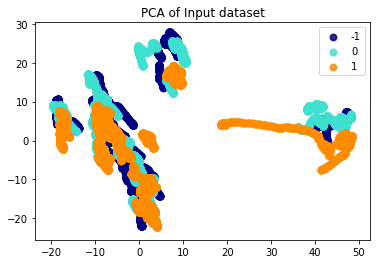

In [30]:
model = SVME(3, C=10, class_weight="balanced")
model.fit(X_train, y_train+1)
y_predict = model.predict(X_train)
visual_2D(X_train, y_predict-1)